<h1>LSTM AutoEncoder Prototype</h1>
Now we have completed our EDA. Let's run this through our AutoEncoder for anomaly detection

In [1]:
#importing the libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import LSTM,Input,Dropout

In [2]:
#load the data
df=pd.read_excel('OracleTags.xlsx',sheet_name='Data')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50089 entries, 0 to 50088
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       50089 non-null  datetime64[ns]
 1   Feed19     50089 non-null  object        
 2   SysP       50089 non-null  object        
 3   ART1       50089 non-null  object        
 4   ART2       50089 non-null  object        
 5   ART3       50089 non-null  object        
 6   Spillback  50089 non-null  object        
 7   DisP01A    50089 non-null  object        
 8   DisP01B    50089 non-null  object        
 9   CompTempA  50089 non-null  object        
 10  CompTempB  50089 non-null  object        
dtypes: datetime64[ns](1), object(10)
memory usage: 4.2+ MB


In [3]:
#preprocessing our data

#change data types
def change_types(df):
    for col in df.columns:
        if df[col].dtypes == 'object':
            df[col] = df[col].apply(pd.to_numeric,errors ='coerce')
    return df

df=change_types(df)

#fill up the null
df=df.fillna(method='ffill')


#check wether ok or not
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50089 entries, 0 to 50088
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       50089 non-null  datetime64[ns]
 1   Feed19     50089 non-null  float64       
 2   SysP       50089 non-null  float64       
 3   ART1       50089 non-null  float64       
 4   ART2       50089 non-null  float64       
 5   ART3       50089 non-null  float64       
 6   Spillback  50089 non-null  float64       
 7   DisP01A    50089 non-null  float64       
 8   DisP01B    50089 non-null  float64       
 9   CompTempA  50089 non-null  float64       
 10  CompTempB  50089 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 4.2 MB


In [4]:
#let's separate all our columns into separate dataframe

# Create a dictionary to store the separate DataFrames with names
split_dfs = {}

# Extract the datetime column
datetime_col = df['Date']

# Split the DataFrame into separate DataFrames for float columns
for col in df.columns[1:]:
    col_df = pd.concat([datetime_col, df[col]], axis=1)
    # Assign a name to each DataFrame using the float column name
    col_name = f'DF_{col}'  # You can change the naming convention as needed
    split_dfs[col_name] = col_df

# Access the separate DataFrames by name
for name, split_df in split_dfs.items():
    print(f"DataFrame {name}:")
    print(split_df)
    print("\n")

DataFrame DF_Feed19:
                     Date     Feed19
0     2018-01-05 00:00:00  97.089645
1     2018-01-05 01:00:00  96.995880
2     2018-01-05 02:00:00  97.105370
3     2018-01-05 03:00:00  97.008598
4     2018-01-05 04:00:00  97.029556
...                   ...        ...
50084 2023-09-22 20:00:00  63.638168
50085 2023-09-22 21:00:00  64.022972
50086 2023-09-22 22:00:00  63.714317
50087 2023-09-22 23:00:00  63.909969
50088 2023-09-23 00:00:00  62.764347

[50089 rows x 2 columns]


DataFrame DF_SysP:
                     Date        SysP
0     2018-01-05 00:00:00  125.097557
1     2018-01-05 01:00:00  125.055153
2     2018-01-05 02:00:00  125.015350
3     2018-01-05 03:00:00  125.041107
4     2018-01-05 04:00:00  125.051071
...                   ...         ...
50084 2023-09-22 20:00:00  125.023697
50085 2023-09-22 21:00:00  124.988838
50086 2023-09-22 22:00:00  125.031059
50087 2023-09-22 23:00:00  124.986664
50088 2023-09-23 00:00:00  125.067299

[50089 rows x 2 columns]


Data

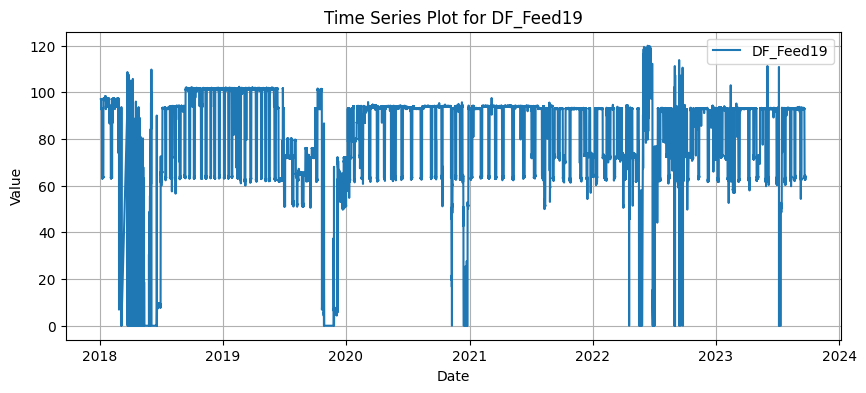

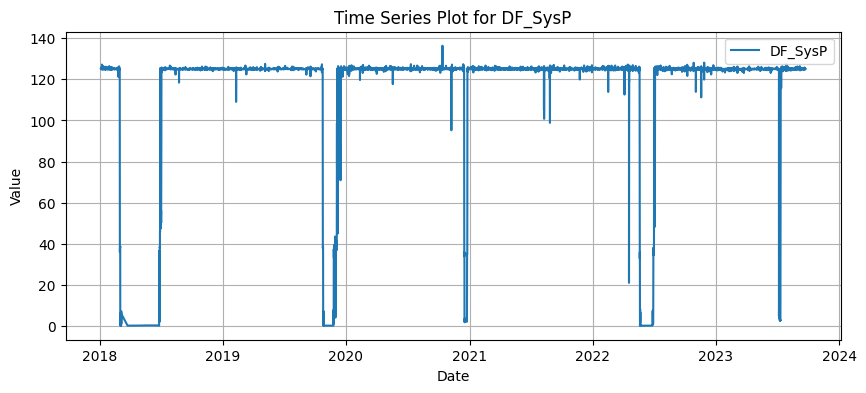

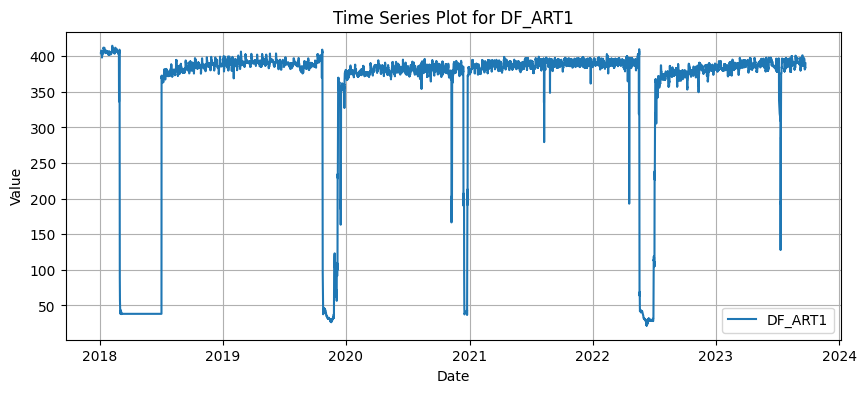

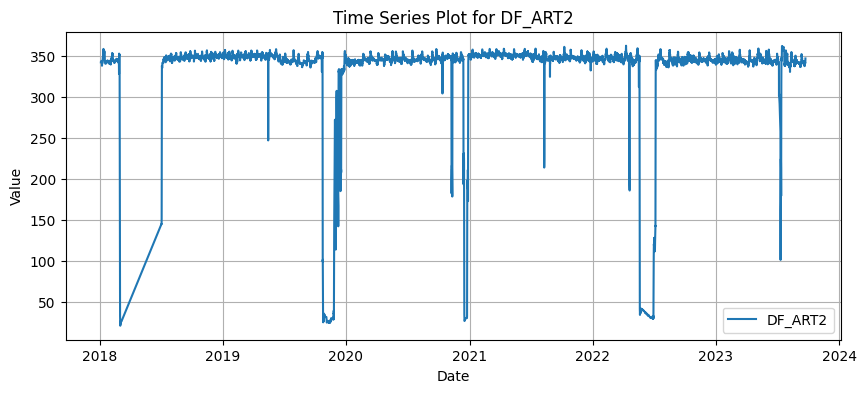

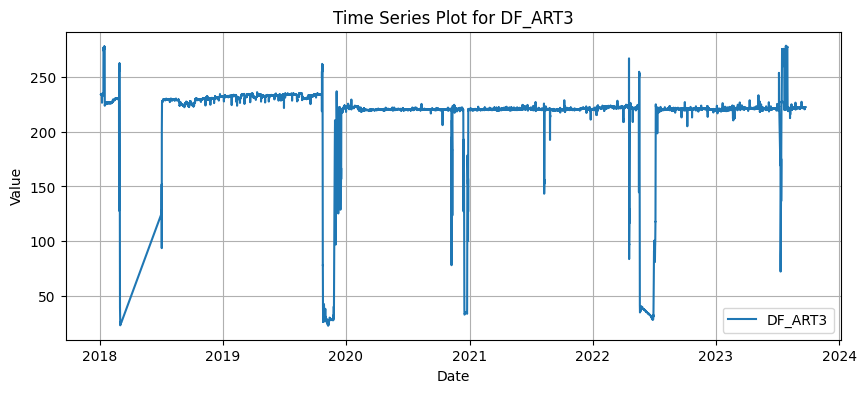

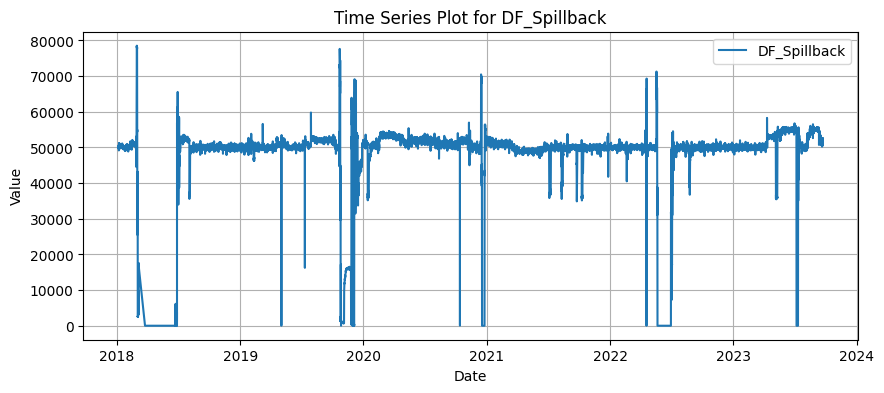

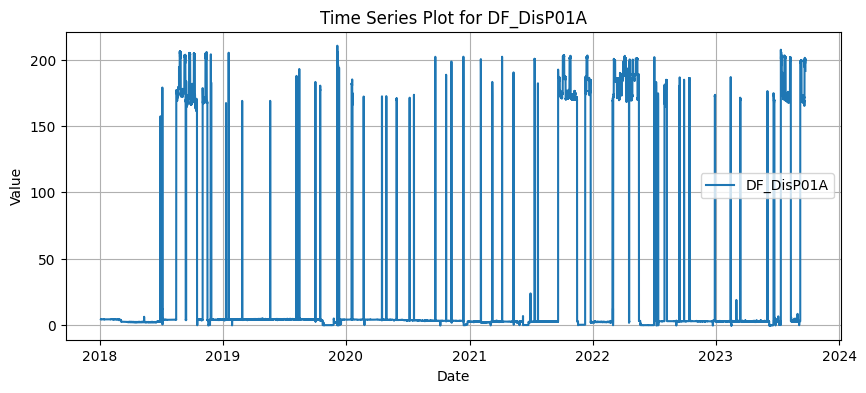

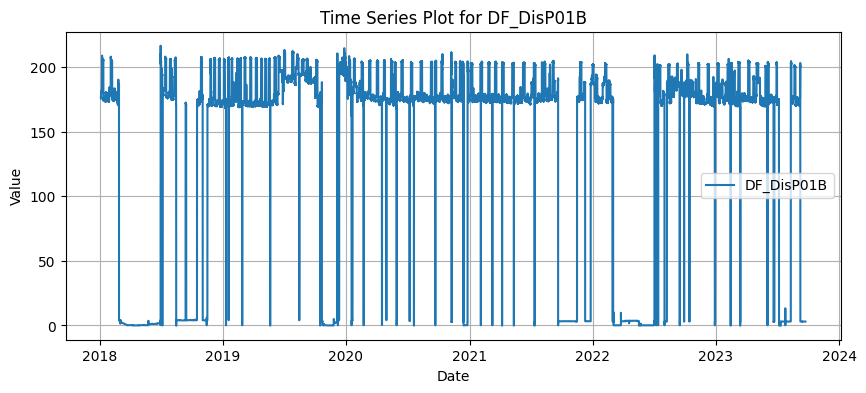

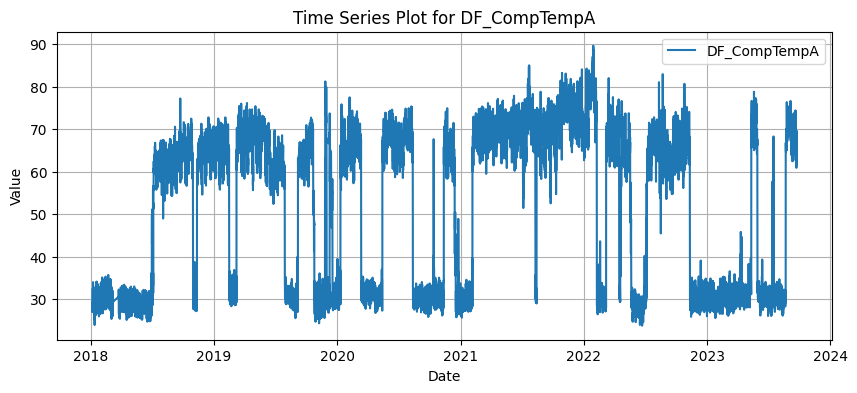

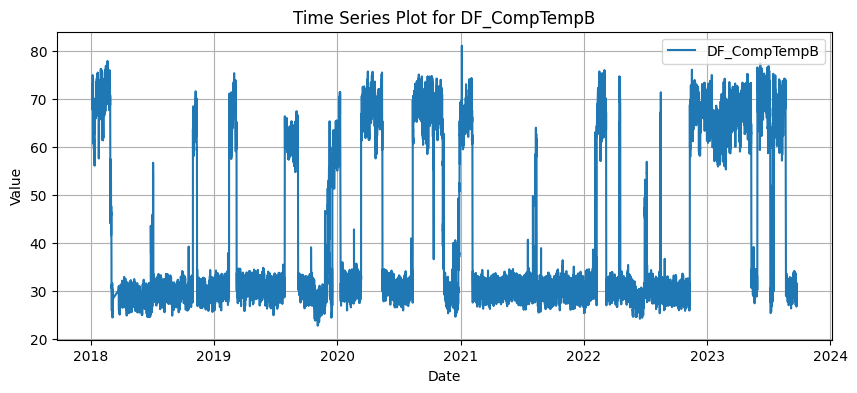

In [5]:
#alright, now let's plot each dataframes by timeseries, to monitor the anomaly vs normal data
# Iterate through the split DataFrames and create individual plots
for name, split_df in split_dfs.items():
    # Extract the datetime column and the data column
    datetime_col = split_df['Date']
    data_col = split_df[name.replace("DF_", "")]  # Extract the relevant data column

    # Create a time series plot for the current DataFrame
    plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
    plt.plot(datetime_col, data_col, label=name)
    plt.title(f"Time Series Plot for {name}")
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    # Display or save the plot
    plt.show()

<h2>Separating Normal and Anomaly Trend</h2>
Now it's time to separate our split dataframe into normal and anomaly trend. Using this, we can feed the normal/anomaly trend to our autoencoder. After learning the trend any reconstruction error that is higher/lower than threshold can be identified as anomaly. Let's do this by identifying the normal and anomaly period

The period separation are as below:
1. Feed (period 2022) (April will be the anomaly trend)
2. SysP or System Pressure (2022) (April will be the anomaly trend)
3. ART 1/ART 2/ART 3 (2022) (April will be the anomaly trend)
4. Compressor Spillback (2022)(April to June will be the anonaly trend)
5. Discharge Pressure P-1901A (2022)(May to June will be the anomaly trend)
6. Discharge Pressure P-1901B (2022)(May to June will be the anomaly trend)
7. K-1901A Compressor cylinder temperature (2021 to 2022)
8. K-1901B Compressor cylinder temperature (2023 early period)